#  PyTorch CNN on MNIST — Step by Step

This notebook demonstrates how to build, train, evaluate, and analyze a
**Convolutional Neural Network (CNN)** using **PyTorch** on the MNIST dataset.

### Why this notebook?
- To translate CNN concepts learned from scratch into PyTorch
- To understand training vs evaluation
- To visualize what CNNs learn internally
- To follow an industry-aligned workflow

> This notebook complements my CNN-from-scratch (NumPy) implementation.


# Imports & Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Device Configuration

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


# 📌 Why this matters:
Production models should always be device-aware.

# Load & Transform MNIST Dataset

In [32]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)

test_dataset = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=64, shuffle=False
)


# 📌 MNIST images: (1 × 28 × 28)

# Visualize Sample Images

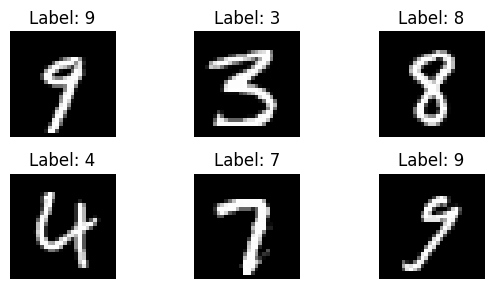

In [4]:
images, labels = next(iter(train_loader))

plt.figure(figsize=(6,3))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(images[i][0], cmap="gray")
    plt.title(f"Label: {labels[i].item()}")
    plt.axis("off")
plt.tight_layout()
plt.show()


# Define CNN Architecture

In [5]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)

        self.fc = nn.Linear(16 * 14 * 14, 10)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = torch.relu(x)
        x = self.pool(x)

        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)

        return x


# 📌 Architecture summary:
Input → Conv → BatchNorm → ReLU → Pool → Flatten → FC


# Initialize Model, Loss, Optimizer

In [6]:
model = CNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [7]:
# 📌 CrossEntropyLoss = Softmax + LogLoss

# Training Function

In [8]:
def train_one_epoch(model, loader):
    model.train()
    running_loss = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(loader)


# Evaluation Function

In [9]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    return 100 * correct / total


# Training Loop

In [10]:
epochs = 5
train_losses = []
test_accuracies = []

for epoch in range(epochs):
    loss = train_one_epoch(model, train_loader)
    acc = evaluate(model, test_loader)

    train_losses.append(loss)
    test_accuracies.append(acc)

    print(f"Epoch [{epoch+1}/{epochs}] | Loss: {loss:.4f} | Accuracy: {acc:.2f}%")


Epoch [1/5] | Loss: 0.2413 | Accuracy: 96.73%
Epoch [2/5] | Loss: 0.1175 | Accuracy: 97.32%
Epoch [3/5] | Loss: 0.0954 | Accuracy: 97.93%
Epoch [4/5] | Loss: 0.0815 | Accuracy: 97.60%
Epoch [5/5] | Loss: 0.0755 | Accuracy: 98.22%


# Plot Training Curves

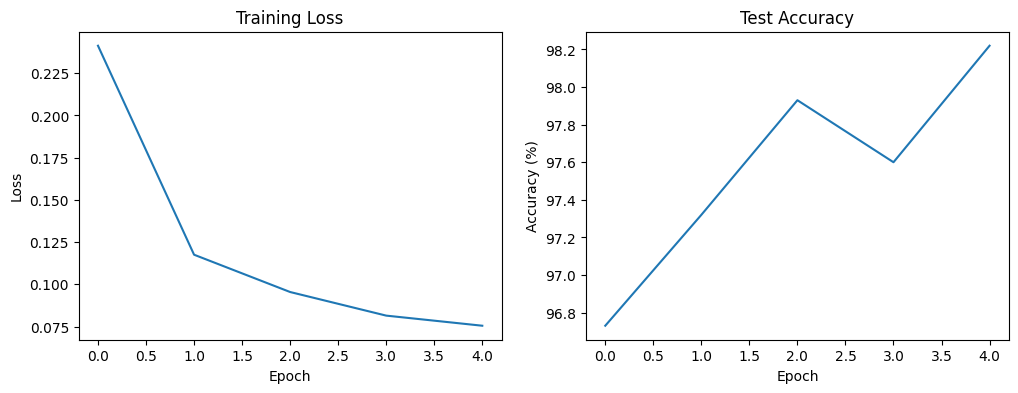

In [11]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(test_accuracies)
plt.title("Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")

plt.show()


# Visualize Learned Filters

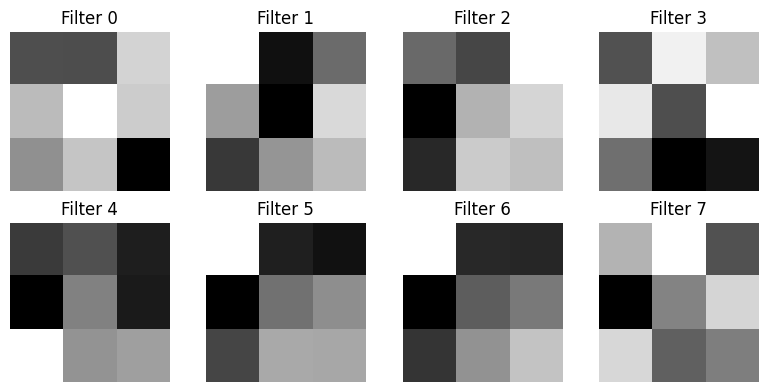

In [12]:
weights = model.conv.weight.data.cpu()

plt.figure(figsize=(8,4))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(weights[i][0], cmap="gray")
    plt.title(f"Filter {i}")
    plt.axis("off")
plt.tight_layout()
plt.show()


# Feature Map Visualization (Hooks)

In [13]:
feature_maps = []

def hook_fn(module, input, output):
    feature_maps.append(output.detach())

hook = model.conv.register_forward_hook(hook_fn)

img = images[0].unsqueeze(0).to(device)
_ = model(img)
hook.remove()

fm = feature_maps[0][0].cpu()


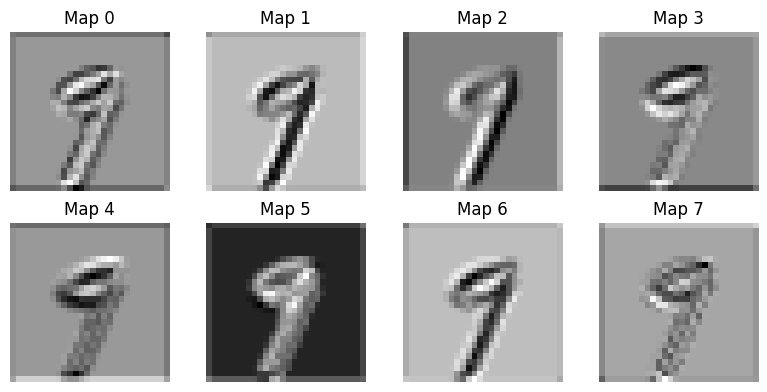

In [14]:
plt.figure(figsize=(8,4))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(fm[i], cmap="gray")
    plt.title(f"Map {i}")
    plt.axis("off")
plt.tight_layout()
plt.show()


# Save Model

In [15]:
torch.save(model.state_dict(), "cnn_mnist.pth")


##  Key Takeaways

- CNNs automatically learn spatial features
- BatchNorm stabilizes training
- Dropout improves generalization
- Adam speeds up convergence
- Feature maps provide interpretability
- PyTorch simplifies gradient computation


# Improved CNN with BatchNorm & Dropout

In [16]:
class ImprovedCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv = nn.Conv2d(1, 16, 3, padding=1)
        self.bn = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(0.3)

        self.fc = nn.Linear(16 * 14 * 14, 10)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = torch.relu(x)
        x = self.pool(x)

        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        return self.fc(x)


In [17]:
model = ImprovedCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


### Why These Improvements Matter

- **Adam** adapts learning rates and converges faster than SGD.
- **Batch Normalization** stabilizes training by normalizing activations.
- **Dropout** prevents overfitting by randomly deactivating neurons.
- `train()` and `eval()` modes ensure correct behavior during training vs inference.


# Training Function

In [18]:
def train_one_epoch(model, loader):
    model.train()
    running_loss = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(loader)


# Evaluation Function

In [19]:
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    return 100 * correct / total


# Training Loop

In [20]:
epochs = 5
train_losses = []
test_accuracies = []

for epoch in range(epochs):
    loss = train_one_epoch(model, train_loader)
    acc = evaluate(model, test_loader)

    train_losses.append(loss)
    test_accuracies.append(acc)

    print(f"Epoch [{epoch+1}/{epochs}] | Loss: {loss:.4f} | Accuracy: {acc:.2f}%")


Epoch [1/5] | Loss: 0.2238 | Accuracy: 96.92%
Epoch [2/5] | Loss: 0.1126 | Accuracy: 97.74%
Epoch [3/5] | Loss: 0.0919 | Accuracy: 97.87%
Epoch [4/5] | Loss: 0.0812 | Accuracy: 98.01%
Epoch [5/5] | Loss: 0.0770 | Accuracy: 97.86%


# Plot Training Curves

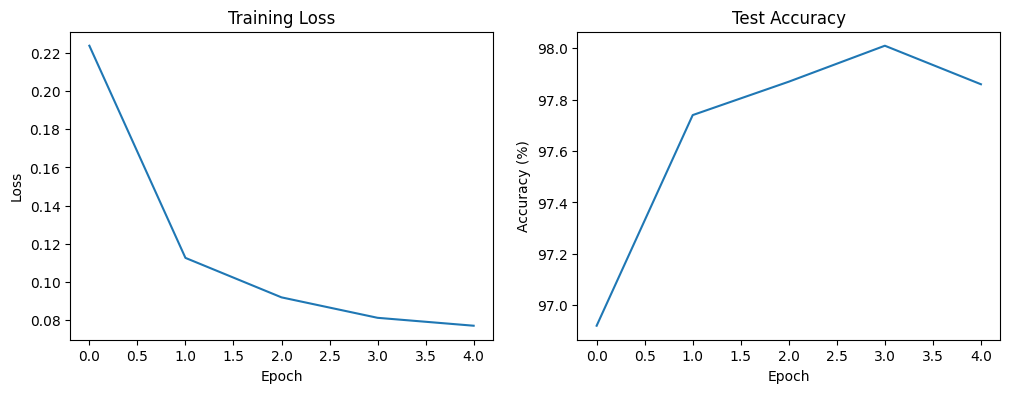

In [21]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(train_losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(test_accuracies)
plt.title("Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")

plt.show()


# Visualize Learned Filters

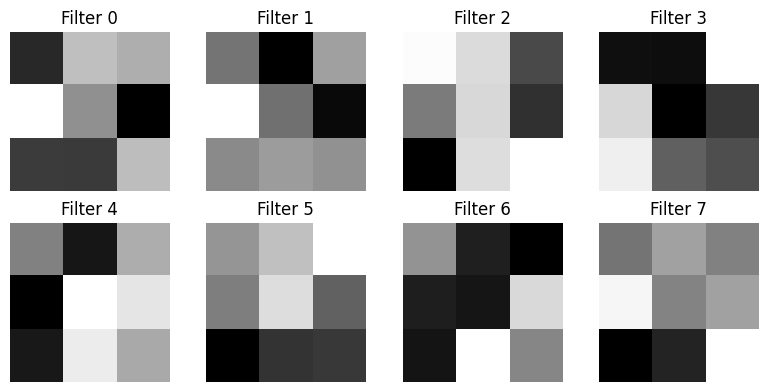

In [22]:
weights = model.conv.weight.data.cpu()

plt.figure(figsize=(8,4))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(weights[i][0], cmap="gray")
    plt.title(f"Filter {i}")
    plt.axis("off")
plt.tight_layout()
plt.show()


# Feature Map Visualization (Hooks)

In [23]:
feature_maps = []

def hook_fn(module, input, output):
    feature_maps.append(output.detach())

hook = model.conv.register_forward_hook(hook_fn)

img = images[0].unsqueeze(0).to(device)
_ = model(img)
hook.remove()

fm = feature_maps[0][0].cpu()


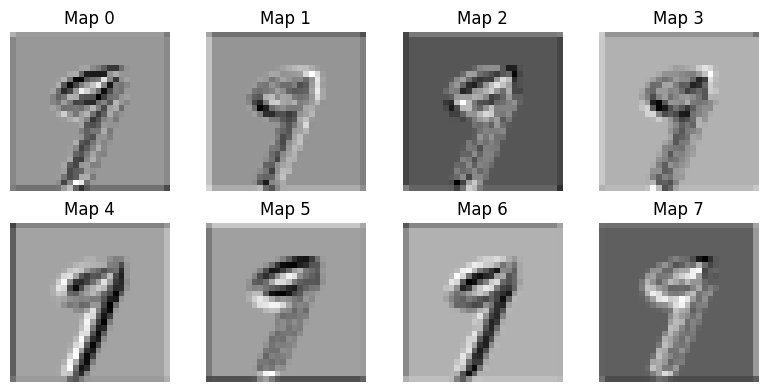

In [24]:
plt.figure(figsize=(8,4))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(fm[i], cmap="gray")
    plt.title(f"Map {i}")
    plt.axis("off")
plt.tight_layout()
plt.show()


# Save Improved Model

In [25]:
torch.save(model.state_dict(), "cnn_mnist.pth")

##  Deep CNNs & ResNet Intuition

As CNNs become deeper, training becomes harder due to vanishing gradients.
ResNet solves this using **residual connections**.


In [26]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        return self.block(x)


In [27]:
class DeepCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.b1 = ConvBlock(1, 32)
        self.b2 = ConvBlock(32, 64)
        self.b3 = ConvBlock(64, 128)
        self.fc = nn.Linear(128 * 3 * 3, 10)

    def forward(self, x):
        x = self.b1(x)
        x = self.b2(x)
        x = self.b3(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


### Why ResNet Works

Instead of learning `H(x)`, ResNet learns:

F(x) + x

This allows gradients to flow directly through skip connections,
solving vanishing gradient problems and enabling very deep networks.


## Transfer Learning with ResNet18

We reuse features learned on ImageNet instead of training from scratch.


In [29]:
import torchvision.models as models

resnet = models.resnet18(pretrained=True)

for param in resnet.parameters():
    param.requires_grad = False

resnet.fc = nn.Linear(resnet.fc.in_features, 10)
resnet = resnet.to(device)


### Fine-Tuning Strategy
- Freeze early layers
- Train classifier head
- Optionally unfreeze last layers for adaptation


In [31]:
torch.save(model.state_dict(), "cnn_mnist_final.pth")


## Final Takeaways

- CNNs learn hierarchical spatial features
- BatchNorm & Dropout improve training stability
- Adam accelerates convergence
- Deeper CNNs capture richer representations
- ResNet enables very deep architectures
- Transfer learning saves data and computation
- PyTorch bridges theory with real-world deployment
